# Use Case Study
From users’ past reviews on businesses on Yelp, figure out how likely her review for another business has five-star.


## Load data

In [468]:
import pandas as pd

PATH = '/scratch/xun/docs/yelp_dataset_challenge_academic_dataset/'
biz_df = pd.read_csv(PATH + 'yelp_academic_dataset_business.csv')
user_df = pd.read_csv(PATH + 'yelp_academic_dataset_user.csv')
review_df = pd.read_csv(PATH + 'yelp_academic_dataset_review.csv')

In [469]:
review_df = review_df.set_index('review_id')
user_df = user_df.set_index('user_id')
biz_df = biz_df.set_index('business_id')

## Visulize the data

### Example: Plot distribution of review star ratings

In [470]:
import seaborn as sns
%matplotlib inline

# Set context to "talk" for figure aesthetics 
sns.set_context(context="talk")
# set plot figure size to larger
sns.set(palette='Set2', rc={"figure.figsize": (15, 8)}, style="ticks")

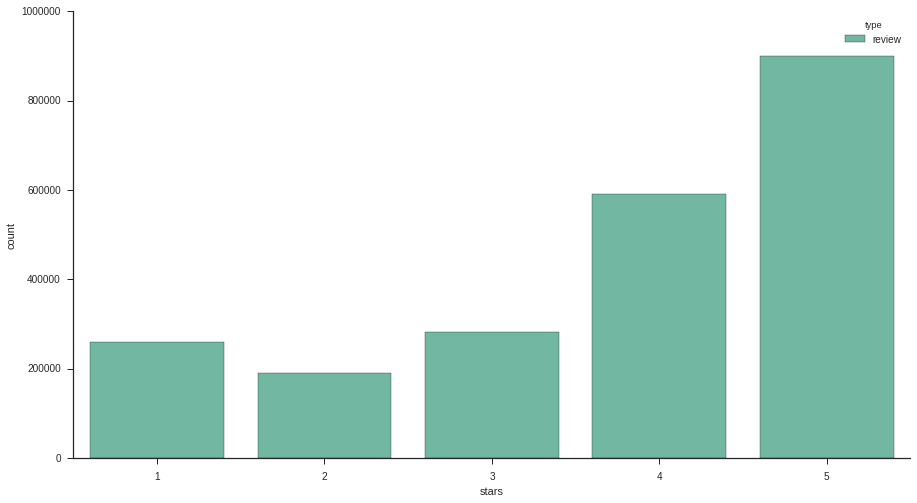

In [471]:
ax = sns.countplot(x='stars', data=review_df, hue='type')
# Rmoving spines
sns.despine()

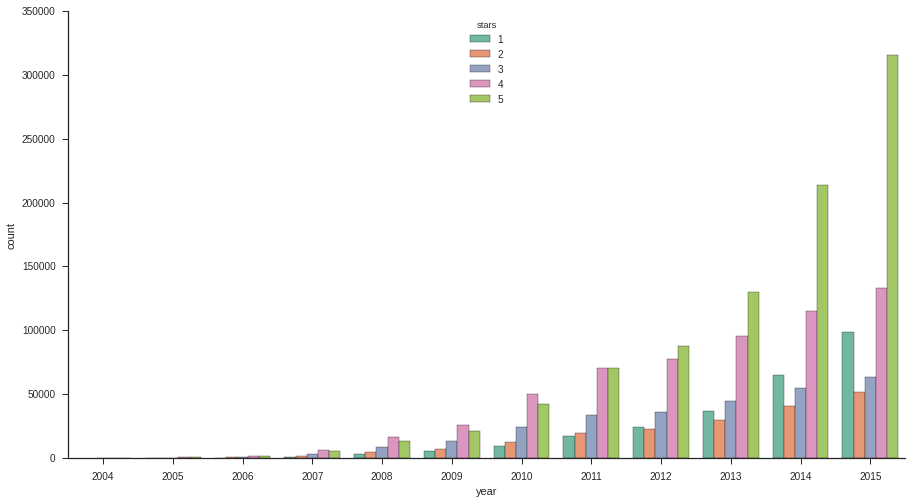

In [472]:
review_df['datetime'] = pd.to_datetime(review_df['date'])
review_df['year'] = review_df['datetime'].dt.year
ax = sns.countplot(x='year', data=review_df, hue='stars')
sns.despine()

## Featurize the data

In [473]:
### Example: Convert categorial features to binary features 

In [474]:
def calculate_date_delta(df, from_column, to_column):
    datetime = pd.to_datetime(df[from_column])
    time_delta = datetime.max() - datetime
    df[to_column] = time_delta.apply(lambda x: x.days)
    df.drop(from_column, axis=1, inplace=True)

In [475]:
def to_length(df, from_column, to_column):
    df[to_column] = df[from_column].apply(lambda x: len(x))
    df.drop(from_column, axis=1, inplace=True)

In [476]:
def drop_columns(df, columns):
    for column in columns:
        df.drop(column, axis=1, inplace=True)

In [477]:
def to_boolean(df, columns):
    for column in columns:
        to_column = column+'_bool'
        df[to_column] = df[column].apply(lambda x: bool(x))
        df.drop(column, axis=1, inplace=True)

In [478]:
FILL_WITH = 0.0

In [479]:
def to_category(df, columns):
    for column in columns:
        df[column] = df[column].astype('category')
        # add FILL_WITH category for fillna() to work w/o error
        if (FILL_WITH not in df[column].cat.categories):
            df[column] = df[column].cat.add_categories([FILL_WITH])
        print 'categories for ', column, ' include ', df[column].cat.categories

In [480]:
def category_rename_to_int(df, columns):
    for column in columns:
        df[column].cat.remove_unused_categories()
        size = len(df[column].cat.categories)
        print 'column ', column, ' has ', size, ' columns, include ', df[column].cat.categories
        df[column] = df[column].cat.rename_categories(range(size))
        print 'becomes ', df[column].cat.categories

In [ ]:
review_df.columns.values

array(['user_id', 'text', 'votes.cool', 'business_id', 'votes.funny',
       'stars', 'date', 'type', 'votes.useful', 'datetime', 'year'], dtype=object)

In [ ]:
calculate_date_delta(df=review_df, from_column='date', to_column='date_delta')

In [ ]:
to_length(df=review_df, from_column='text', to_column='text_len')

In [ ]:
drop_columns(df=review_df, columns=['type', 'year', 'datetime'])

In [ ]:
review_df.fillna(value=0.0, inplace=True)

In [ ]:
calculate_date_delta(df=user_df, from_column='yelping_since', to_column='date_delta')

In [ ]:
to_length(df=user_df, from_column='friends', to_column='friends_count')

In [ ]:
to_length(df=user_df, from_column='elite', to_column='elite_count')

In [ ]:
drop_columns(df=user_df, columns=['name', 'type'])

In [ ]:
user_df.fillna(value=0.0, inplace=True)

In [ ]:
drop_columns(
    df=biz_df,
    columns=[
        'type',
        'name',
        'city',
        'full_address',
        'state',
        'categories',
        'longitude',
        'latitude',
        'neighborhoods',
        'hours.Monday.open',
        'hours.Monday.close',
        'hours.Tuesday.open',
        'hours.Tuesday.close',
        'hours.Wednesday.open',
        'hours.Wednesday.close',
        'hours.Thursday.open',
        'hours.Thursday.close',
        'hours.Friday.open',
        'hours.Friday.close',
        'hours.Saturday.open',
        'hours.Saturday.close',
        'hours.Sunday.open',
        'hours.Sunday.close',
    ]
)

In [ ]:
to_cat_columns = [
    'attributes.Ambience.casual',
    'attributes.Attire',
    'attributes.Alcohol',
    'attributes.Noise Level',
    'attributes.Smoking',
    'attributes.Wi-Fi',
    'attributes.Ages Allowed',
]
to_category(
    df=biz_df,
    columns=to_cat_columns,
)

In [ ]:
biz_df.fillna(value=FILL_WITH, inplace=True)

In [ ]:
category_rename_to_int(
    df=biz_df,
    columns=to_cat_columns,
)

#### Join three tables (review, biz, user) to one (review-with-all-info)

Each join is a many-to-one join: 
The `user_df` DataFrame is already indexed by the join key (`user_id`). Make sure it's on the right side of join.

In [ ]:
review_join_user = review_df.join(user_df, on='user_id', lsuffix='_review', rsuffix='_user')

In [ ]:
review_join_user_join_biz = review_join_user.join(biz_df, on='business_id', rsuffix='_biz')

In [ ]:
drop_columns(df=review_join_user_join_biz, columns=['user_id', 'business_id'])

In [ ]:
review_join_user_join_biz.columns.values

In [ ]:
review_join_user_join_biz.head(1)

# Identify data X and target y

In [ ]:
# target y is whether a review is five-star
y = review_join_user_join_biz.stars.apply(lambda x: x == 5)

# We've already dropped not informative features data X
X = review_join_user_join_biz
review_join_user_join_biz.drop('stars', axis=1, inplace=True)

# get the feature names - this will be useful for the model visualization and feature analysis
features = X.columns.values

In [ ]:
from sklearn import preprocessing

def label_encode(df, columns):
    label_encoders = []
    for column in columns:
        le = preprocessing.LabelEncoder()
        label_encoders.append(le)

        #to convert into numbers
        df[column] = le.fit_transform(df[column])
        
    return label_encoders

def label_decode(df, columns, label_encoders):
    # XXX(xun): columns have to be the same order as label_encode()
    for column, le in zip(columns, label_encoders):
        #to convert back
        df[column] = le.inverse_transform(df[column])

In [ ]:
columns_need_encode = [
    'attributes.BYOB/Corkage',
]
les = label_encode(
    df=X,
    columns=columns_need_encode,
)
#label_decode(df=df, columns=columns_need_encode, label_encoders=les)

In [ ]:
X.head(3).to_string()

In [ ]:
from sklearn.cross_validation import train_test_split

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
print 'training data shape', X_train.shape
print 'test data shape', X_test.shape
print 'converted label data shape', y_train.shape
###print 'features', features

## Model the data

### Logistic regression

Estimate the probability of a binary response based on one or more features. The probability of a review being five-star.

Benefits:
- Fast
- Stable
- Can handle sparse data

Disadvantages:
- Necessary to normalize data
- Data must be numeric

Parameters:
- penalty: Used to specify the norm used in the penalization ('l1' or 'l2'). Default = 'l2'.
- C: Inverse of regularization strength, smaller values specify stronger regularization. It must be a positive float. Default = 1.0.
- tol: Tolerance for stopping criteria. Default = 0.0001.

#### Standardize features

In [ ]:
# Standardize features by removing the mean and scaling to unit variance
scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Build model

In [ ]:
from sklearn import linear_model

# Build model using default parameter values
lrc = linear_model.LogisticRegression()

# cross-validation 
cv = StratifiedKFold(y, n_folds=5, shuffle=True)
training_score(lrc, X_train_scaled, y, cv)

#### Evaluation via Confusion Matrix (false positive; false negative) 

In [ ]:
# Compute confusion matrix
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Split the data into a training set and a test set
X_train, X_test, Y_train, Y_test = train_test_split(X, y)

# Run classifier
Y_pred = lrc.fit(X_train, Y_train).predict(X_test)
cm = confusion_matrix(Y_test, Y_pred)

# Compute confusion matrix
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
plt.show()

### Make prediction with the model

In [ ]:
# give a prediction of user:me evaluating biz:gary danco, get the prob. of me giving it a five-star
# another example of me for another biz (park, street, civic center bart station) and give negative